In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as f
from pathlib import Path
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Dataset
import os
from torchsummary import torchsummary

In [2]:
ORIGINAL_IMAGE = '/import/mqhome/duanct/dataSets/NDI_images/20220725/20220725/Observed_Crop_200x200pix'
TARGET_IMAGE = '/import/mqhome/duanct/dataSets/NDI_images/20220725/20220725/Calculated_200x200/grayscale'
POSITIVE_RATIO = 0.1
BATCH_SIZE = 16

## CosineEmbeddingLoss

In [16]:
class NDI_dataset(Dataset):
    def __init__(self, positive_ratio=0.5, times=10):
        original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
        target_images = list(Path(TARGET_IMAGE).glob('*.jpg'))
        self.origins, self.targets, self.label = [], [], []
        for original_image in original_images:
            self.origins.append(torchvision.io.read_image(str(original_image)))
            self.targets.append(torchvision.io.read_image(str(Path.joinpath(Path(TARGET_IMAGE), original_image.name.split('_')[0] + '.jpg'))))
            self.label.append(torch.tensor(1))
        for _ in range(times):
            for original_image in original_images:
                self.origins.append(torchvision.io.read_image(str(original_image)))
                self.targets.append(torchvision.io.read_image(str(np.random.choice(target_images))))
                self.label.append(torch.tensor(-1))

    def __getitem__(self, idx):
        return self.origins[idx], self.targets[idx], self.label[idx]

    def __len__(self):
        return len(self.origins)

In [17]:
train_iter = DataLoader(NDI_dataset(POSITIVE_RATIO), BATCH_SIZE, shuffle=True)

In [5]:
model = torchvision.models.resnet18(pretrained=False)

In [6]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(512, 256)

In [7]:
torchsummary.summary(model, input_size=(1, 200, 200), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           3,136
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,

In [ ]:
device = torch.device('cuda')
lr = 0.001
EPOCHS = 20

loss = nn.CosineEmbeddingLoss(margin=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
train_iter = DataLoader(NDI_dataset(POSITIVE_RATIO), BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for origin, target, label in train_iter:
        optimizer.zero_grad()
        origin, target = origin.float(), target.float()
        origin, target, label = origin.to(device), target.to(device), label.to(device)
        origin_feature = model(origin)
        target_feature = model(target)
        l = loss(origin_feature, target_feature, label)
        l.backward()
        total_loss += l
    print(f'Epoch: {epoch + 1}, Ave. Loss: {total_loss / len(train_iter):.4f}')


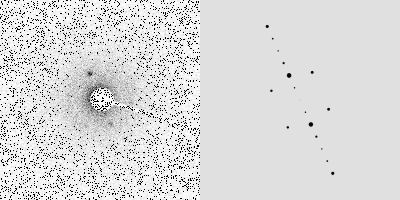

tensor([0.9943], grad_fn=<DivBackward0>)


In [15]:
from PIL import Image

model.to('cpu')
original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
original_image_name = np.random.choice(original_images)
original_image = torchvision.io.read_image(str(original_image_name)).unsqueeze_(0).float()
target_image = torchvision.io.read_image(str(Path.joinpath(Path(TARGET_IMAGE), original_image_name.name.split('_')[0] + '.jpg'))).unsqueeze_(0).float()
img = torchvision.transforms.ToPILImage()(torch.cat([original_image, target_image], dim=3).squeeze(0))
img.show()
print(nn.CosineSimilarity()(model(original_image), model(target_image)))

In [ ]:
model.to('cpu')
original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
target_images = list(Path(TARGET_IMAGE).glob('*.jpg'))
original_image_name = np.random.choice(original_images)
target_image_name = np.random.choice(target_images)
original_image = torchvision.io.read_image(str(original_image_name)).unsqueeze_(0).float()
target_image = torchvision.io.read_image(str(target_image_name)).unsqueeze_(0).float()
print(nn.CosineSimilarity()(model(original_image), model(target_image)))

In [ ]:
dimensions = 512
a = torch.rand((1, dimensions))
b = torch.rand((1, dimensions))
nn.CosineSimilarity()(a, b)

In [21]:
ORIGINAL_IMAGE = '/import/mqhome/duanct/dataSets/NDI_images/20220725/20220725/Observed_Crop_200x200pix/binaryzation_pics'
TARGET_IMAGE = '/import/mqhome/duanct/dataSets/NDI_images/20220725/20220725/Calculated_200x200/grayscale'
POSITIVE_RATIO = 0.1
BATCH_SIZE = 16

train_iter = DataLoader(NDI_dataset(POSITIVE_RATIO), BATCH_SIZE, shuffle=True)

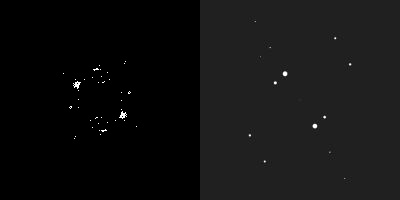

In [24]:
for x1, x2, y in train_iter:
    x1 = x1[0]
    x2 = x2[0]
    img = torchvision.transforms.ToPILImage()(torch.cat([x1, x2], dim=2).squeeze(0))
    img.show()
    break

In [25]:
model = torchvision.models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(512, 256)
device = torch.device('cuda')
lr = 0.001
EPOCHS = 20

loss = nn.CosineEmbeddingLoss(margin=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
train_iter = DataLoader(NDI_dataset(POSITIVE_RATIO), BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for origin, target, label in train_iter:
        optimizer.zero_grad()
        origin, target = origin.float(), target.float()
        origin, target, label = origin.to(device), target.to(device), label.to(device)
        origin_feature = model(origin)
        target_feature = model(target)
        l = loss(origin_feature, target_feature, label)
        l.backward()
        total_loss += l
    print(f'Epoch: {epoch + 1}, Ave. Loss: {total_loss / len(train_iter):.4f}')

Epoch: 1, Ave. Loss: 0.5840
Epoch: 2, Ave. Loss: 0.5914
Epoch: 3, Ave. Loss: 0.5924
Epoch: 4, Ave. Loss: 0.5930
Epoch: 5, Ave. Loss: 0.5921
Epoch: 6, Ave. Loss: 0.5920
Epoch: 7, Ave. Loss: 0.5920
Epoch: 8, Ave. Loss: 0.5918
Epoch: 9, Ave. Loss: 0.5926
Epoch: 10, Ave. Loss: 0.5916
Epoch: 11, Ave. Loss: 0.5920
Epoch: 12, Ave. Loss: 0.5922
Epoch: 13, Ave. Loss: 0.5929
Epoch: 14, Ave. Loss: 0.5914
Epoch: 15, Ave. Loss: 0.5922
Epoch: 16, Ave. Loss: 0.5841
Epoch: 17, Ave. Loss: 0.5925
Epoch: 18, Ave. Loss: 0.5927
Epoch: 19, Ave. Loss: 0.5846
Epoch: 20, Ave. Loss: 0.5926


In [ ]:
from PIL import Image

model.to('cpu')
original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
original_image_name = np.random.choice(original_images)
original_image = torchvision.io.read_image(str(original_image_name)).unsqueeze_(0).float()
target_image = torchvision.io.read_image(str(Path.joinpath(Path(TARGET_IMAGE), original_image_name.name.split('_')[0] + '.jpg'))).unsqueeze_(0).float()
img = torchvision.transforms.ToPILImage()(torch.cat([original_image, target_image], dim=3).squeeze(0))
img.show()
print(nn.CosineSimilarity()(model(original_image), model(target_image)))

In [ ]:
model.to('cpu')
original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
target_images = list(Path(TARGET_IMAGE).glob('*.jpg'))
original_image_name = np.random.choice(original_images)
target_image_name = np.random.choice(target_images)
original_image = torchvision.io.read_image(str(original_image_name)).unsqueeze_(0).float()
target_image = torchvision.io.read_image(str(target_image_name)).unsqueeze_(0).float()
print(nn.CosineSimilarity()(model(original_image), model(target_image)))

## Binary Classification

In [4]:
a = torch.rand((8, 512))
b = torch.rand((8, 512))
torch.cat([a, b], dim=-1).size()

torch.Size([8, 1024])

In [5]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=False)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Linear(512, 256)
        self.classifier = nn.Linear(512, 2)
    def forward(self, origin, target):
        origin_feature = f.relu(self.backbone(origin))
        target_feature = f.relu(self.backbone(target))
        return self.classifier(torch.cat([origin_feature, target_feature], dim=-1))

In [61]:
class NDI_dataset_classifier_random_sample(Dataset):
    def __init__(self, positive_ratio=0.5, times=10):
        original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
        target_images = list(Path(TARGET_IMAGE).glob('*.jpg'))
        self.origins, self.targets, self.label = [], [], []
        for _ in range(times):
            for original_image in original_images:
                if torch.rand() < positive_ratio:
                    self.origins.append(torchvision.io.read_image(str(original_image)))
                    self.targets.append(torchvision.io.read_image(str(Path.joinpath(Path(TARGET_IMAGE), original_image.name.split('_')[0] + '.jpg'))))
                    self.label.append(torch.tensor(1, dtype=torch.long))
                else:
                    self.origins.append(torchvision.io.read_image(str(original_image)))
                    self.targets.append(torchvision.io.read_image(str(np.random.choice(target_images))))
                    self.label.append(torch.tensor(0, dtype=torch.long))

    def __getitem__(self, idx):
        return self.origins[idx], self.targets[idx], self.label[idx]

    def __len__(self):
        return len(self.origins)

In [46]:
class NDI_dataset_classifier(Dataset):
    def __init__(self, positive_ratio=0.5, times=10):
        original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
        target_images = list(Path(TARGET_IMAGE).glob('*.jpg'))
        self.origins, self.targets, self.label = [], [], []
        for original_image in original_images:
            self.origins.append(torchvision.io.read_image(str(original_image)))
            self.targets.append(torchvision.io.read_image(str(Path.joinpath(Path(TARGET_IMAGE), original_image.name.split('_')[0] + '.jpg'))))
            self.label.append(torch.tensor(1, dtype=torch.long))
        for _ in range(times):
            for original_image in original_images:
                self.origins.append(torchvision.io.read_image(str(original_image)))
                self.targets.append(torchvision.io.read_image(str(np.random.choice(target_images))))
                self.label.append(torch.tensor(0, dtype=torch.long))

    def __getitem__(self, idx):
        return self.origins[idx], self.targets[idx], self.label[idx]

    def __len__(self):
        return len(self.origins)

In [68]:
model = ClassificationModel()
torchsummary.summary(model, input_size=[(1, 200, 200), (1, 200, 200)], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           3,136
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,

In [74]:
device = torch.device('cuda')
lr = 0.01
EPOCHS = 10

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
train_iter = DataLoader(NDI_dataset_classifier(0.2, times=30), BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total_number = 0
    for origin, target, label in train_iter:
        optimizer.zero_grad()
        origin, target = origin.float(), target.float()
        origin, target, label = origin.to(device), target.to(device), label.to(device)
        logits = model(origin, target)
        correct += float((torch.argmax(logits, dim=-1).type(label.dtype) == label).sum())
        total_number += label.numel()
        l = loss(logits, label)
        l.backward()
        total_loss += l
    print(f'Epoch: {epoch + 1}, Ave. Loss: {total_loss / len(train_iter):.4f}, Acc: {correct / total_number}')

Epoch: 1, Ave. Loss: 0.9642, Acc: 0.03225806451612903
Epoch: 2, Ave. Loss: 0.9638, Acc: 0.03225806451612903
Epoch: 3, Ave. Loss: 0.9641, Acc: 0.03225806451612903
Epoch: 4, Ave. Loss: 0.9640, Acc: 0.03225806451612903
Epoch: 5, Ave. Loss: 0.9637, Acc: 0.03225806451612903
Epoch: 6, Ave. Loss: 0.9639, Acc: 0.03225806451612903
Epoch: 7, Ave. Loss: 0.9638, Acc: 0.03225806451612903
Epoch: 8, Ave. Loss: 0.9636, Acc: 0.03225806451612903
Epoch: 9, Ave. Loss: 0.9635, Acc: 0.03225806451612903
Epoch: 10, Ave. Loss: 0.9636, Acc: 0.03225806451612903
Epoch: 1, Ave. Loss: 0.9643, Acc: 0.03225806451612903
Epoch: 2, Ave. Loss: 0.9641, Acc: 0.03225806451612903
Epoch: 3, Ave. Loss: 0.9640, Acc: 0.03225806451612903
Epoch: 4, Ave. Loss: 0.9643, Acc: 0.03225806451612903
Epoch: 5, Ave. Loss: 0.9646, Acc: 0.03225806451612903
Epoch: 6, Ave. Loss: 0.9641, Acc: 0.03225806451612903
Epoch: 7, Ave. Loss: 0.9644, Acc: 0.03225806451612903
Epoch: 8, Ave. Loss: 0.9644, Acc: 0.03225806451612903
Epoch: 9, Ave. Loss: 0.9643

In [75]:
model.to('cpu')
original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
original_image_name = np.random.choice(original_images)
original_image = torchvision.io.read_image(str(original_image_name)).unsqueeze_(0).float()
target_image = torchvision.io.read_image(str(Path.joinpath(Path(TARGET_IMAGE), original_image_name.name.split('_')[0] + '.jpg'))).unsqueeze_(0).float()
print(model(original_image, target_image))
print(torch.argmax(model(original_image, target_image)))

tensor([[-0.2264,  0.3188]], grad_fn=<AddmmBackward0>)
tensor(1)


In [76]:
model.to('cpu')
original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
target_images = list(Path(TARGET_IMAGE).glob('*.jpg'))
original_image_name = np.random.choice(original_images)
target_image_name = np.random.choice(target_images)
original_image = torchvision.io.read_image(str(original_image_name)).unsqueeze_(0).float()
target_image = torchvision.io.read_image(str(target_image_name)).unsqueeze_(0).float()
print(model(original_image, target_image))
print(torch.argmax(model(original_image, target_image)))

tensor([[-0.2071,  0.3173]], grad_fn=<AddmmBackward0>)
tensor(1)


In [9]:
class StackedClassificationModel(nn.Module):
    def __init__(self):
        super(StackedClassificationModel, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=False)
        self.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Linear(512, 2)
    def forward(self, origin, target):
        return self.backbone(torch.cat([origin_feature, target_feature], dim=1))

Fri Aug 19 15:46:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   36C    P0    36W / 250W |   1115MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:AF:00.0 Off |                    0 |
| N/A   

In [ ]:
model = ClassificationModel()
torchsummary.summary(model, input_size=[(1, 200, 200), (1, 200, 200)], device='cpu')